In [11]:
import sys
import os

%load_ext autoreload
%autoreload 2

# Add parent directory to path
sys.path.append(os.path.abspath('..'))

# Import the MatLab prior work

from other_algs.teralasso import TeraLasso
from other_algs.EiGLasso import EiGLasso

# Standard imports

from new_validation import *
from generate_data import *
from regularizers import *

# Matplotlib
from cycler import cycler
linestyle_cycler = cycler('linestyle',['-','--',':','-.'])
color_cycler = cycler('color',['k','orange','m','darkgreen'])
plt.rc('axes', prop_cycle=linestyle_cycler + color_cycler)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from statistics import median
from matplotlib import cycler
from python_frontend.GmGM import GmGM
from other_algs.EiGLasso import EiGLasso
from other_algs.teralasso import TeraLasso
from python_frontend.generate_data import *

import timeit

# Code

In [13]:
def generate_timing_data_smart(
    algorithms: dict[str, callable],
    sizes: list[int],
    K: int,
    attempts: int, 
    num_samples: int,
    cutoff: int = 60,
    verbose: bool = False
):  
    includes: dict[str, bool] = {}
    times: dict[str, list[float]] = {}
    
    for algorithm in algorithms:
        includes[algorithm]: bool = True
        times[algorithm]: list[float] = []
    for d in sizes:
        if not any(includes.values()):
            if verbose:
                print("All algorithms timed out")
            break
        if verbose:
            print(f"Starting {(d,) * K}")

        # Generate Data
        structure = {
            "dataset_0": tuple(f"axis_{j}" for j in range(K))
        }
        sub_generators = {
            f"axis_{i}": PrecMatGenerator(
                core_type="coreless",
                mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            )
            for i in range(K)
        }
        generator = DatasetGenerator(
            structure=structure,
            generator=sub_generators,
            size={axis: d for axis in structure["dataset_0"]},
        )
        generator.reroll_Ψs()
        dataset = generator.generate({"dataset_0": 1})

        # Test algorithms
        for algorithm in algorithms.keys():
            if not includes[algorithm]:
                continue
            times[algorithm].append(0)
            durations = timeit.Timer(
                lambda: algorithms[algorithm](dataset, generator.structure)
            ).repeat(
                repeat=attempts,
                number=1
            )
            times[algorithm][-1] = median(durations)
            if times[algorithm][-1] >= cutoff:
                if verbose:
                    print(f"{algorithm} ran for longer than {cutoff} seconds")
                    print(f"{algorithm} is no longer being tracked")
                includes[algorithm] = False
            else:
                if verbose:
                    print(f"\t{algorithm}: {times[algorithm][-1]} Seconds")
    print("Done")
    return times

In [14]:
def GmGM_for_stats(dataset, structure, λ, reg: Regularizer = None):
    output = GmGM(
        dataset,
        structure,
        regularizer=reg,
        _always_regularize=True,
        _check_overstep_each_iter=True,
        tol=1e-5
    )
    axes: set[Axis] = {
        axis
        for axes in structure.values()
        for axis in axes
    }
    output = shrink_sparsities(output, {axis: λ for axis in axes})
    return output

def GmGM_reg_and_thresh(cutoff=1e-5, reg=None):
    def to_return(dataset, structure, λ):
        output = GmGM(
            dataset,
            structure,
            regularizer=reg,
            _always_regularize=True,
            _check_overstep_each_iter=True,
            tol=1e-5
        )
        axes: set[Axis] = {
            axis
            for axes in structure.values()
            for axis in axes
        }
        for axis in axes:
            if axis not in output:
                continue
            Psi = output[axis]
            Psi[np.abs(Psi) < cutoff*np.max(np.abs(Psi)) / λ] = 0
            output[axis] = Psi
        return output
    return to_return

def TeraLasso_for_stats(dataset, structure, λ, reg: Regularizer = None):
    # Recall that TeraLasso takes a single matrix/tensor as input
    name, dataset = list(dataset.items())[0]

    # Input into TeraLasso
    betas = [λ] * (dataset.ndim - 1)
    output = TeraLasso(dataset, betas=betas)

    # Skip first as that will be batch
    axes = structure[name][1:]

    return {axis: out for axis, out in zip(axes, output)}

def EiGLasso_for_stats(dataset, structure, λ, reg: Regularizer = None):
    # Recall that TeraLasso takes a single matrix/tensor as input
    name, dataset = list(dataset.items())[0]

    # Input into TeraLasso
    output = EiGLasso(dataset, λ, λ)

    # Skip first as that will be batch
    axes = structure[name][1:]

    return {axes[0]: output[0], axes[1]: output[1]}

# Experiment 1: Matrix-Variate Data

In [15]:
algorithms = {
    "GmGM": lambda dataset, structure: GmGM_for_stats(dataset, structure, 0.1),
    "GmGM L1": lambda dataset, structure: GmGM_reg_and_thresh(1e-5)(dataset, structure, 0.1),
    "TeraLasso": lambda dataset, structure: TeraLasso_for_stats(dataset, structure, 0.1),
    "EiGLasso": lambda dataset, structure: EiGLasso_for_stats(dataset, structure, 0.1),
}
size_data = [
    100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,
    1100, 1200, 1300, 1400, 1500, 1750, 2000, 2250, 2500,
    3000, 3500, 4000,
]
timing_data = generate_timing_data_smart(
    algorithms=algorithms,
    sizes=size_data,
    K=2,
    attempts=1,
    num_samples=1,
    verbose=True
)

Starting (100, 100)
	GmGM: 0.011769917000492569 Seconds
	GmGM L1: 0.011515791004057974 Seconds
	TeraLasso: 3.1935047500010114 Seconds
	EiGLasso: 0.050358416003291495 Seconds
Starting (200, 200)
	GmGM: 0.08837554199999431 Seconds
	GmGM L1: 0.09548420799546875 Seconds
	TeraLasso: 4.321428499999456 Seconds
	EiGLasso: 0.2170942919983645 Seconds
Starting (300, 300)
	GmGM: 0.19602937500167172 Seconds
	GmGM L1: 0.18542095799784875 Seconds
	TeraLasso: 10.597283583003446 Seconds
	EiGLasso: 0.7487428750027902 Seconds
Starting (400, 400)
	GmGM: 0.35751654200430494 Seconds
	GmGM L1: 0.3514741250037332 Seconds
	TeraLasso: 9.91608916700352 Seconds
	EiGLasso: 1.8402924159963732 Seconds
Starting (500, 500)
	GmGM: 0.5796233329965617 Seconds
	GmGM L1: 0.5705701249971753 Seconds
	TeraLasso: 46.38446158300212 Seconds
	EiGLasso: 3.3927892499996233 Seconds
Starting (600, 600)
	GmGM: 0.8579207499933545 Seconds
	GmGM L1: 0.8438328750053188 Seconds
	TeraLasso: 32.580699917001766 Seconds
	EiGLasso: 7.0736087910

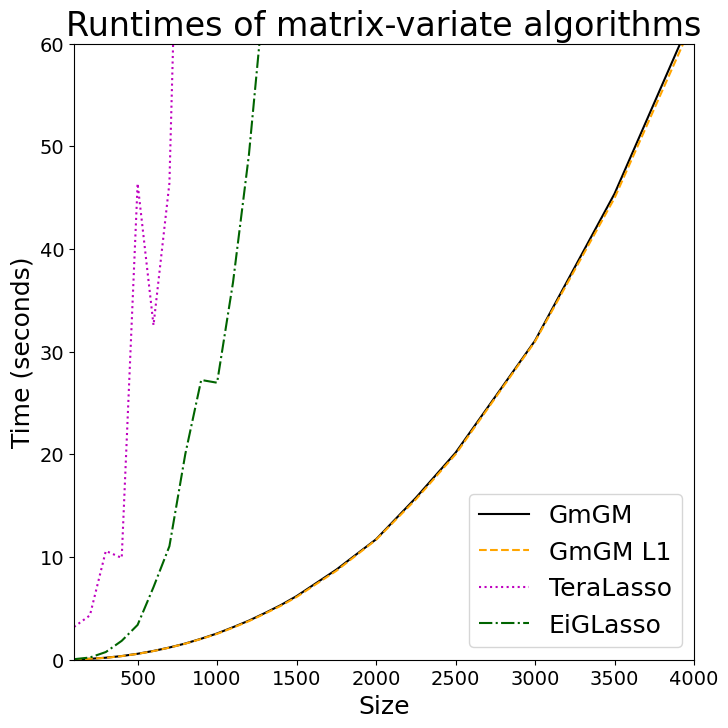

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data):
    ax.plot(
        size_data[:len(timing_data[algorithm])],
        timing_data[algorithm],
        label=algorithm,
        #linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of matrix-variate algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data[0], size_data[-1]])
ax.legend(fontsize=18)

In [17]:
fig.savefig("../out_figs/matrix-runtime.png")
fig.savefig("../out_figs/matrix-runtime.svg")

# Experiment 2: Tensor-Variate Data

In [18]:
algorithms = {
    "GmGM": lambda dataset, structure: GmGM_for_stats(dataset, structure, 0.1),
    "GmGM L1": lambda dataset, structure: GmGM_reg_and_thresh(1e-5)(dataset, structure, 0.1),
    "TeraLasso": lambda dataset, structure: TeraLasso_for_stats(dataset, structure, 0.1),
}
size_data = [
    10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
    110, 120, 130, 140, 150, 160, 200, 250, 300, 350, 400,
]
timing_data = generate_timing_data_smart(
    algorithms=algorithms,
    sizes=size_data,
    K=3,
    attempts=1,
    num_samples=1,
    verbose=True
)

Starting (10, 10, 10)
	GmGM: 0.0006965830034459941 Seconds
	GmGM L1: 0.001375833002384752 Seconds
	TeraLasso: 0.45920220800326206 Seconds
Starting (20, 20, 20)
	GmGM: 0.0027470829954836518 Seconds
	GmGM L1: 0.0023125840016291477 Seconds
	TeraLasso: 1.034155292007199 Seconds
Starting (30, 30, 30)
	GmGM: 0.004241250004270114 Seconds
	GmGM L1: 0.003985374998592306 Seconds
	TeraLasso: 1.5710364999977173 Seconds
Starting (40, 40, 40)
	GmGM: 0.005959542002528906 Seconds
	GmGM L1: 0.005981665999570396 Seconds
	TeraLasso: 1.0323915420012781 Seconds
Starting (50, 50, 50)
	GmGM: 0.0073922500014305115 Seconds
	GmGM L1: 0.009068208004464395 Seconds
	TeraLasso: 2.059674290998373 Seconds
Starting (60, 60, 60)
	GmGM: 0.014478958997642621 Seconds
	GmGM L1: 0.015506209005252458 Seconds
	TeraLasso: 16.227442499999597 Seconds
Starting (70, 70, 70)
	GmGM: 0.02652216600108659 Seconds
	GmGM L1: 0.021947541994450148 Seconds
	TeraLasso: 19.013231125005404 Seconds
Starting (80, 80, 80)
	GmGM: 0.168404500000178

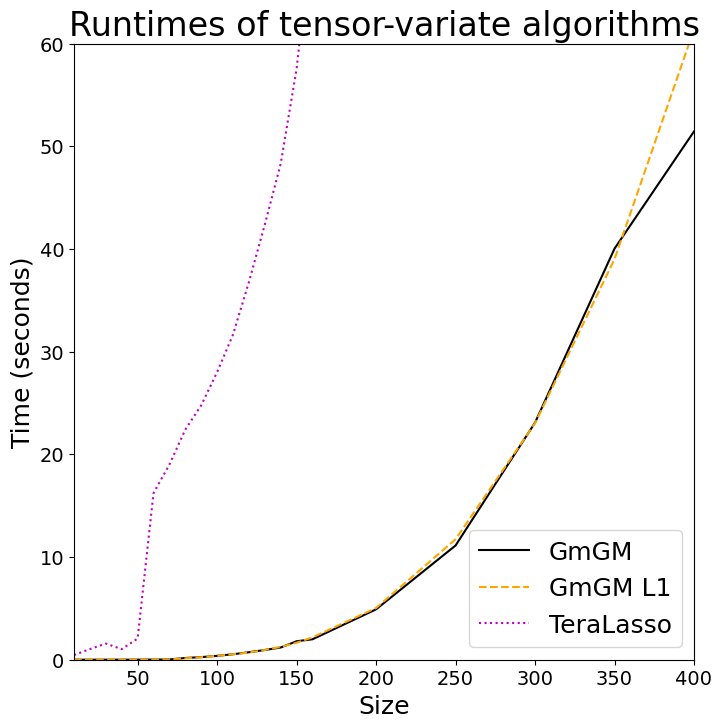

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data):
    ax.plot(
        size_data[:len(timing_data[algorithm])],
        timing_data[algorithm],
        label=algorithm,
        #linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of tensor-variate algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data[0], size_data[-1]])
ax.legend(fontsize=18)

In [20]:
fig.savefig("../out_figs/tensor-runtime.png")
fig.savefig("../out_figs/tensor-runtime.svg")

# Experiment 3: 4-Axis Algorithms

In [21]:
algorithms = {
    "GmGM": lambda dataset, structure: GmGM_for_stats(dataset, structure, 0.1),
    "GmGM L1": lambda dataset, structure: GmGM_reg_and_thresh(1e-5)(dataset, structure, 0.1),
    "TeraLasso": lambda dataset, structure: TeraLasso_for_stats(dataset, structure, 0.1),
}
size_data = [
    10, 20, 30, 40, 50, 60, 70, 80, 90, 100
]
timing_data = generate_timing_data_smart(
    algorithms=algorithms,
    sizes=size_data,
    K=4,
    attempts=1,
    num_samples=1,
    verbose=True
)

Starting (10, 10, 10, 10)
	GmGM: 0.003325541998492554 Seconds
	GmGM L1: 0.003028083003300708 Seconds
	TeraLasso: 0.811097375000827 Seconds
Starting (20, 20, 20, 20)
	GmGM: 0.018442708998918533 Seconds
	GmGM L1: 0.015569832998153288 Seconds
	TeraLasso: 13.515886083994701 Seconds
Starting (30, 30, 30, 30)
	GmGM: 0.06670329200278502 Seconds
	GmGM L1: 0.05420866700296756 Seconds
	TeraLasso: 21.778151083999546 Seconds
Starting (40, 40, 40, 40)
	GmGM: 0.19832758299889974 Seconds
	GmGM L1: 0.1910152089985786 Seconds
	TeraLasso: 41.95555283399881 Seconds
Starting (50, 50, 50, 50)
	GmGM: 0.5738090000013472 Seconds
	GmGM L1: 0.47159812500467524 Seconds
TeraLasso ran for longer than 60 seconds
TeraLasso is no longer being tracked
Starting (60, 60, 60, 60)
	GmGM: 0.9980475420015864 Seconds
	GmGM L1: 1.1095546249998733 Seconds
Starting (70, 70, 70, 70)
	GmGM: 2.132191625001724 Seconds
	GmGM L1: 2.0374078750028275 Seconds
Starting (80, 80, 80, 80)
	GmGM: 3.183103041999857 Seconds
	GmGM L1: 3.8744587

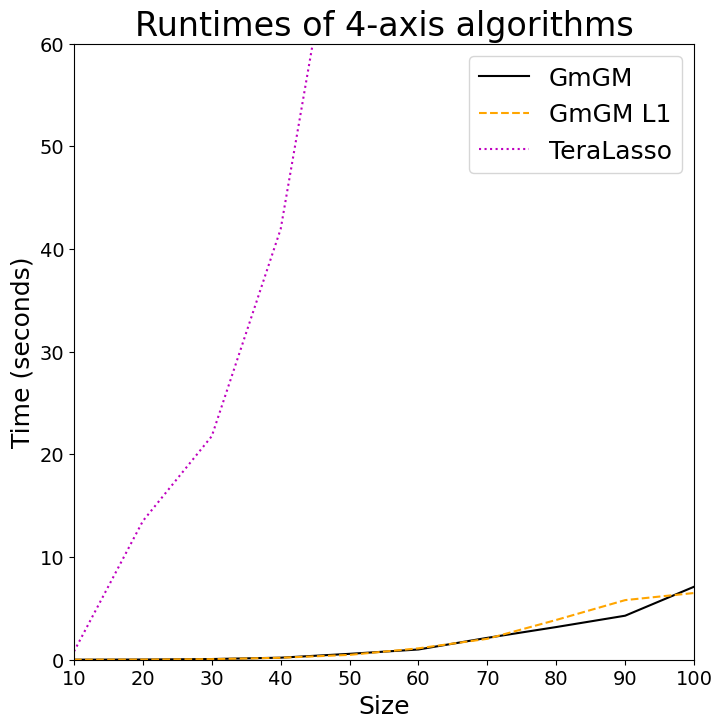

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data):
    ax.plot(
        size_data[:len(timing_data[algorithm])],
        timing_data[algorithm],
        label=algorithm,
        #linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of 4-axis algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data[0], size_data[-1]])
ax.legend(fontsize=18)

In [23]:
fig.savefig("../out_figs/4-axis-runtime.png")
fig.savefig("../out_figs/4-axis-runtime.svg")

# Experiment 4: 5-axes

In [24]:
algorithms = {
    "GmGM": lambda dataset, structure: GmGM_for_stats(dataset, structure, 0.1),
    "GmGM L1": lambda dataset, structure: GmGM_reg_and_thresh(1e-5)(dataset, structure, 0.1),
    "TeraLasso": lambda dataset, structure: TeraLasso_for_stats(dataset, structure, 0.1),
}
size_data = [
    5, 10, 15, 20, 25, 30, 35, 40
]
timing_data = generate_timing_data_smart(
    algorithms=algorithms,
    sizes=size_data,
    K=5,
    attempts=1,
    num_samples=1,
    verbose=True
)

Starting (5, 5, 5, 5, 5)
	GmGM: 0.003634874999988824 Seconds
	GmGM L1: 0.0027497499977471307 Seconds
	TeraLasso: 0.22905558299680706 Seconds
Starting (10, 10, 10, 10, 10)
	GmGM: 0.01890849999472266 Seconds
	GmGM L1: 0.012798791001841892 Seconds
	TeraLasso: 12.668729625002015 Seconds
Starting (15, 15, 15, 15, 15)
	GmGM: 0.08388554100383772 Seconds
	GmGM L1: 0.06541183299850672 Seconds
	TeraLasso: 21.223851458002173 Seconds
Starting (20, 20, 20, 20, 20)
	GmGM: 0.32651391699619126 Seconds
	GmGM L1: 0.35172050000255695 Seconds
	TeraLasso: 49.87670370900014 Seconds
Starting (25, 25, 25, 25, 25)
	GmGM: 1.0598250000039116 Seconds
	GmGM L1: 0.8804283330027829 Seconds
TeraLasso ran for longer than 60 seconds
TeraLasso is no longer being tracked
Starting (30, 30, 30, 30, 30)
	GmGM: 2.5186531670042314 Seconds
	GmGM L1: 2.1698026250014664 Seconds
Starting (35, 35, 35, 35, 35)
	GmGM: 4.714823249996698 Seconds
	GmGM L1: 4.710508582997136 Seconds
Starting (40, 40, 40, 40, 40)
	GmGM: 9.478113791003125

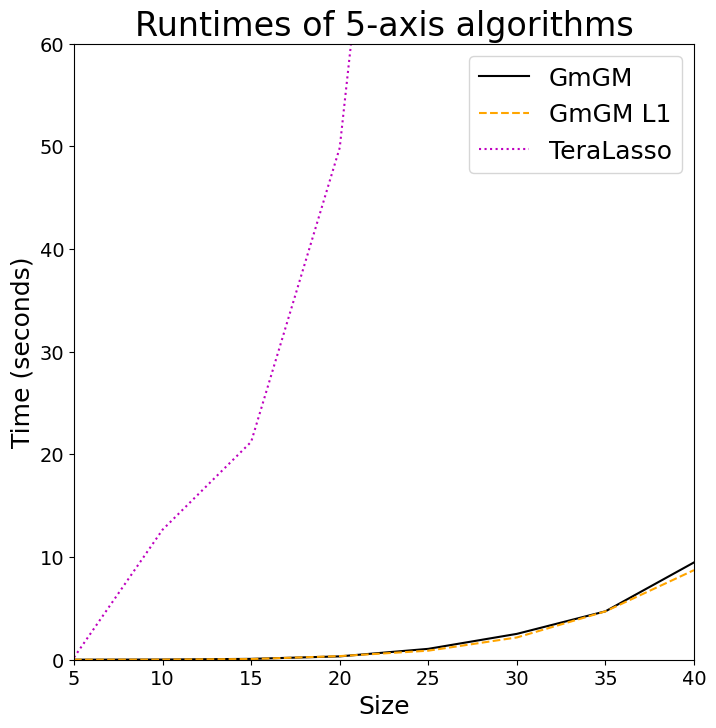

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data):
    ax.plot(
        size_data[:len(timing_data[algorithm])],
        timing_data[algorithm],
        label=algorithm,
        #linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of 5-axis algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data[0], size_data[-1]])
ax.legend(fontsize=18)

In [26]:
fig.savefig("../out_figs/5-axis-runtime.png")
fig.savefig("../out_figs/5-axis-runtime.svg")

# Experiment 5: 6-way axes

In [27]:
algorithms = {
    "GmGM": lambda dataset, structure: GmGM_for_stats(dataset, structure, 0.1),
    "GmGM L1": lambda dataset, structure: GmGM_reg_and_thresh(1e-5)(dataset, structure, 0.1),
    "TeraLasso": lambda dataset, structure: TeraLasso_for_stats(dataset, structure, 0.1),
}
size_data = [
    5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20
]
timing_data = generate_timing_data_smart(
    algorithms=algorithms,
    sizes=size_data,
    K=6,
    attempts=1,
    num_samples=1,
    verbose=True
)

Starting (5, 5, 5, 5, 5, 5)
	GmGM: 0.007032167006400414 Seconds
	GmGM L1: 0.006377083002007566 Seconds
	TeraLasso: 0.39609091699821874 Seconds
Starting (6, 6, 6, 6, 6, 6)
	GmGM: 0.012272416999621782 Seconds
	GmGM L1: 0.015139834002184216 Seconds
	TeraLasso: 0.9044553749990882 Seconds
Starting (7, 7, 7, 7, 7, 7)
	GmGM: 0.018086541997035965 Seconds
	GmGM L1: 0.021899707993725315 Seconds
	TeraLasso: 11.574086166998313 Seconds
Starting (8, 8, 8, 8, 8, 8)
	GmGM: 0.034466958000848535 Seconds
	GmGM L1: 0.034130291001929436 Seconds
	TeraLasso: 13.997889874997782 Seconds
Starting (9, 9, 9, 9, 9, 9)
	GmGM: 0.05682087499735644 Seconds
	GmGM L1: 0.044640207997872494 Seconds
	TeraLasso: 17.614291167003103 Seconds
Starting (10, 10, 10, 10, 10, 10)
	GmGM: 0.1081625829974655 Seconds
	GmGM L1: 0.10687179199885577 Seconds
	TeraLasso: 25.506336500002362 Seconds
Starting (11, 11, 11, 11, 11, 11)
	GmGM: 0.17546766700252192 Seconds
	GmGM L1: 0.20059029100229964 Seconds
	TeraLasso: 34.80548929100041 Seconds


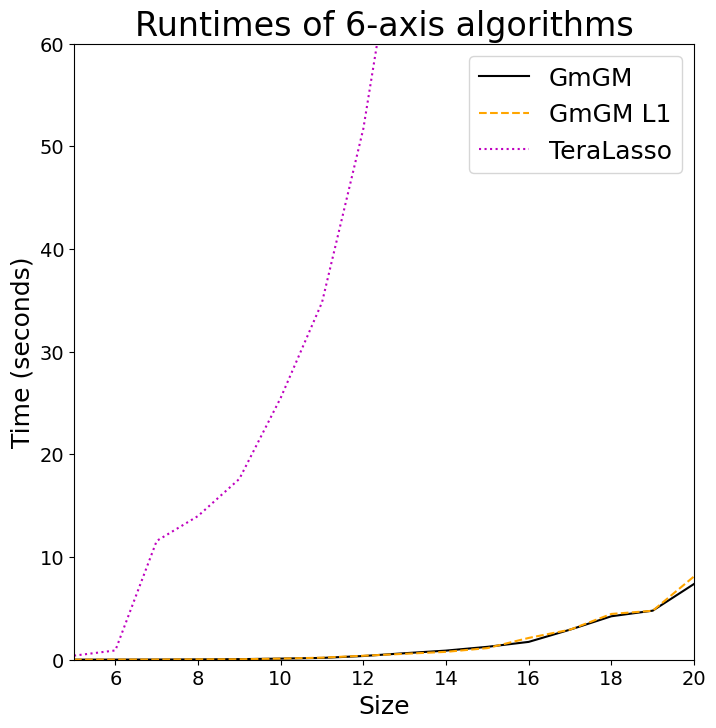

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data):
    ax.plot(
        size_data[:len(timing_data[algorithm])],
        timing_data[algorithm],
        label=algorithm,
        #linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of 6-axis algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data[0], size_data[-1]])
ax.legend(fontsize=18)

In [29]:
fig.savefig("../out_figs/6-axis-runtime.png")
fig.savefig("../out_figs/6-axis-runtime.svg")